In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [4]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [6]:
ResultsDir = "/groups/gerlich/labinfo/2023_Batty_et_al/emboj_revised_submission/fig_by_fig_emboj_revised_manuscript/ev_figures/fig_ev4/panel_d/output/"

In [7]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [8]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [9]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#2045 minus - Hoechst, 0.056, 0.056, 0.089, 0.128, 0.140, 0.143 
#2045 minus - NIPBL, 5.886, 5.745, 6.068, 7.525, 7.310, 7.572 >>> 6.68






In [10]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):
    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_nipbl = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[0,:,:]
        nipbl = data[1,:,:]
        #display_slice(wapl_ha)
        
        #hoechst = hoechst - 0.137
        #nipbl = nipbl - 7.469
         
          
        #hoechst[hoechst < 10] = 0
        
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(6)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 20000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_nipbl = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, 
             properties=properties_nipbl))
        output_nipbl = output_nipbl.rename(columns={"mean_intensity":"mean_nipbl"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_nipbl["total_nuclear_nipbl"] = output_hoechst["nuclear_area_microns"] * output_nipbl["mean_nipbl"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, extra_properties=[image_stdev]))
        
        output_nipbl["std_nipbl"] = props_nipbl["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_nipbl = all_nipbl.append(output_nipbl)
       
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_nipbl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["image_name", "nuclear_area_microns", "mean_hoechst", "mean_nipbl", "total_hoechst", "total_nuclear_nipbl", "std_hoechst", "std_nipbl"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_nipbl"] = final_df["std_nipbl"]/final_df["mean_nipbl"]
    final_df["condition"] = "2045_plus_auxin"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "2045_plus_auxin_fields.csv"), index = False)
    return final_df


/tmp/ipykernel_27685/2002519752.py:32: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2045_plus_aux_stain_hoechst_nipbl_pos26-37 #11.tif


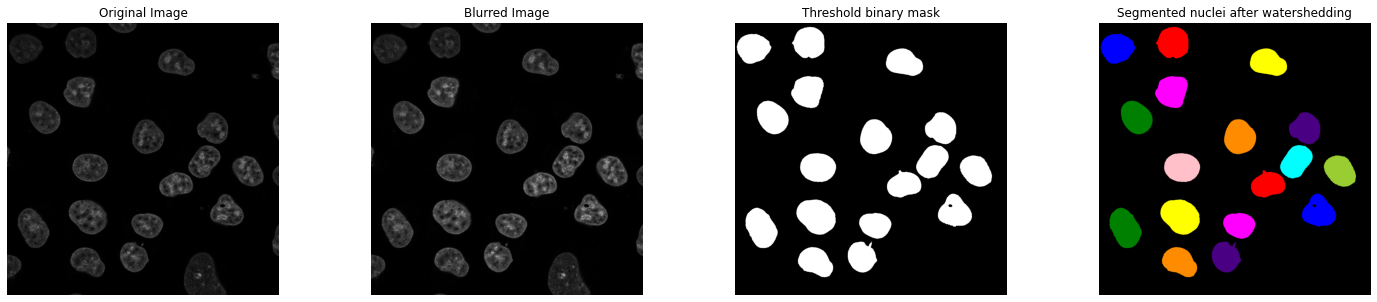

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #1.tif


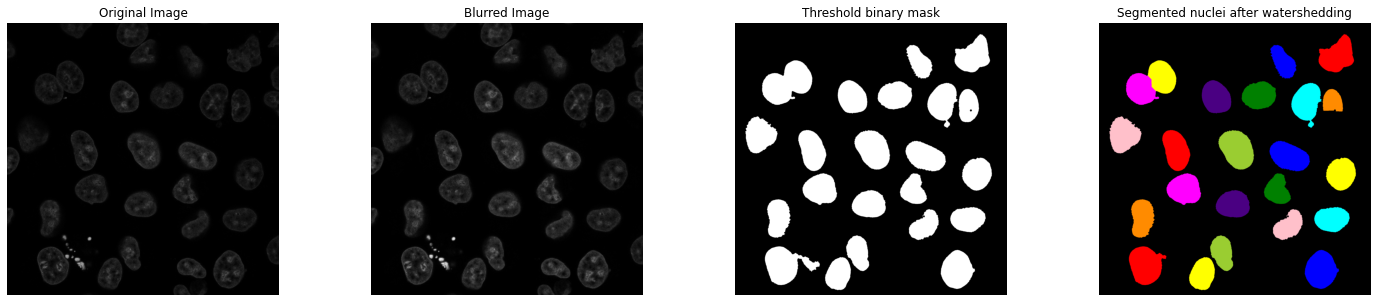

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #2.tif


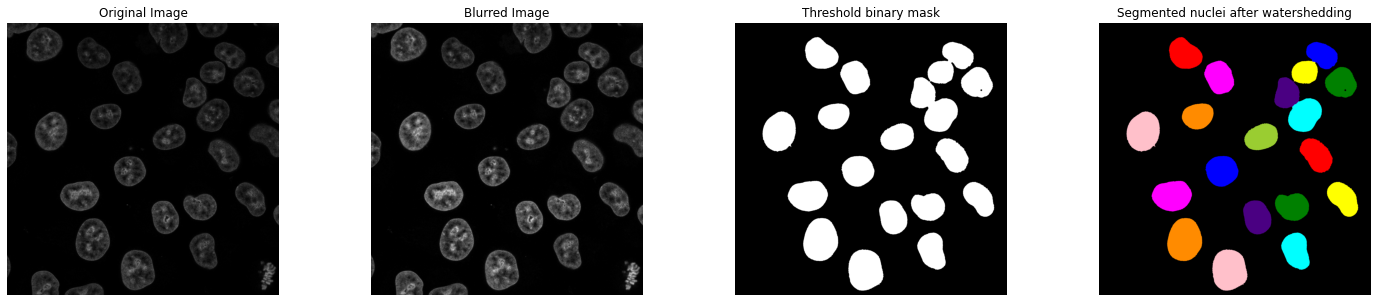

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #3.tif


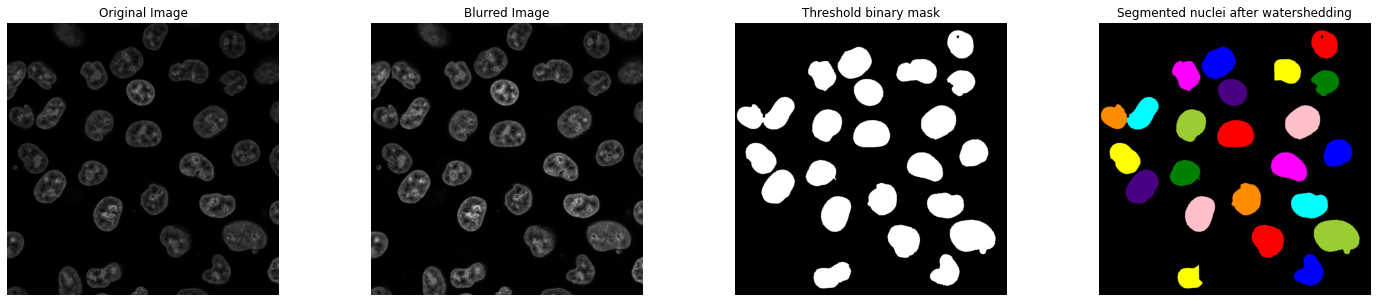

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #4.tif


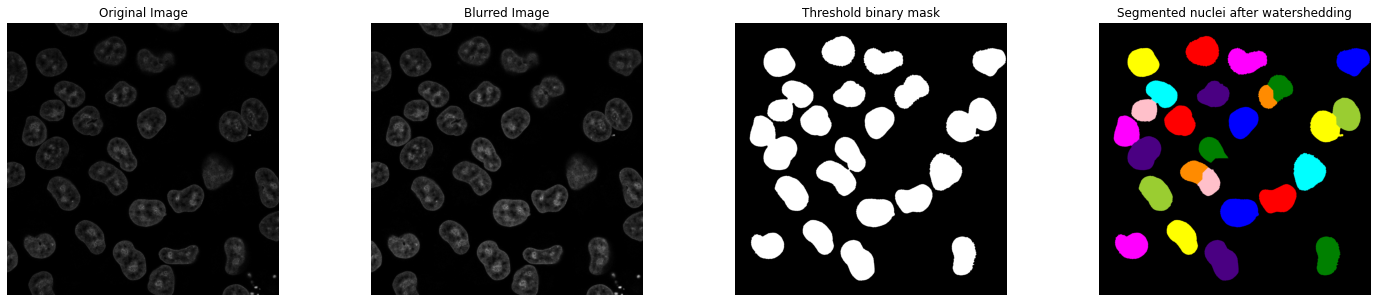

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #5.tif


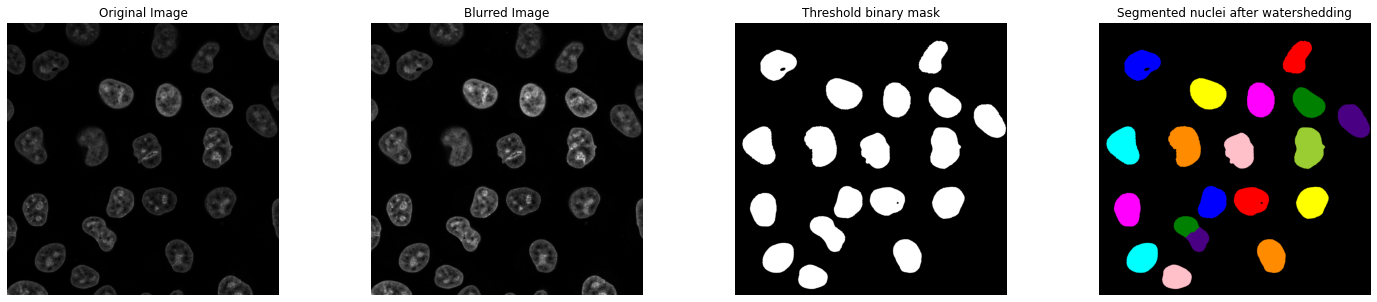

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #6.tif


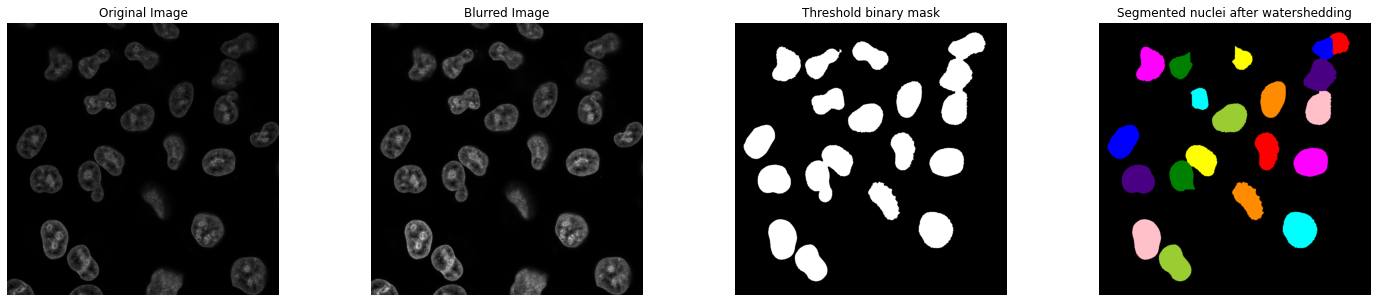

2045_plus_aux_stain_hoechst_nipbl_pos1-10 #7.tif


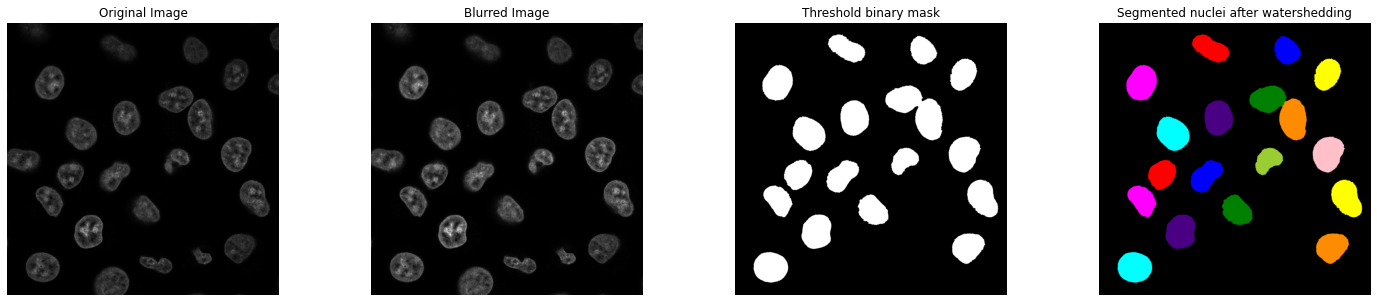

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #1.tif


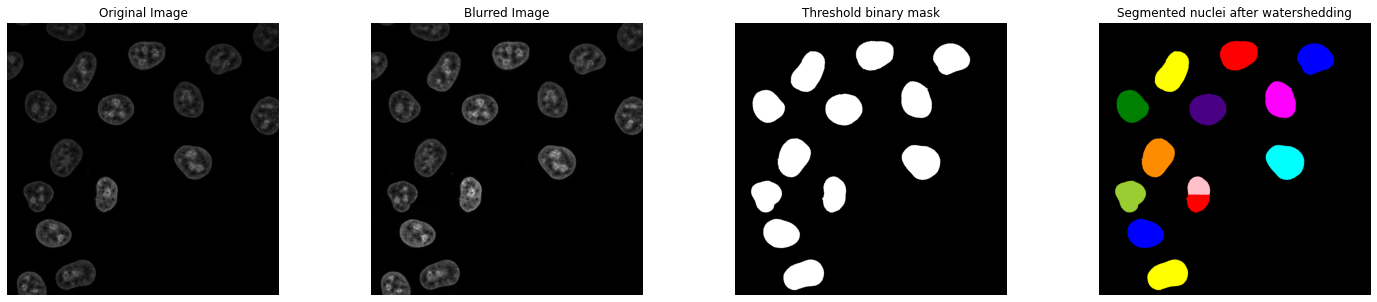

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #2.tif


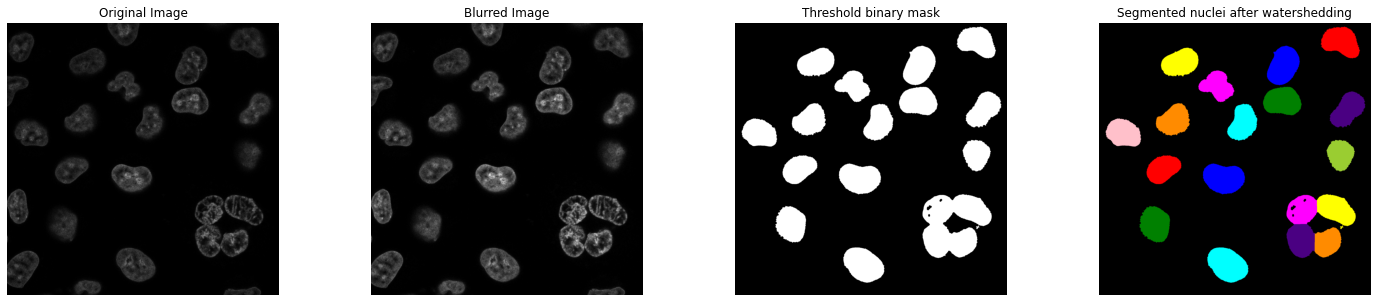

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #3.tif


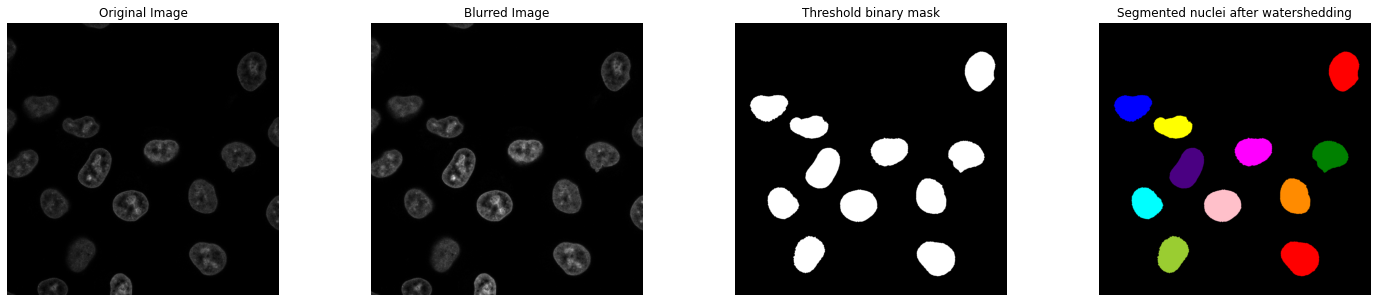

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #4.tif


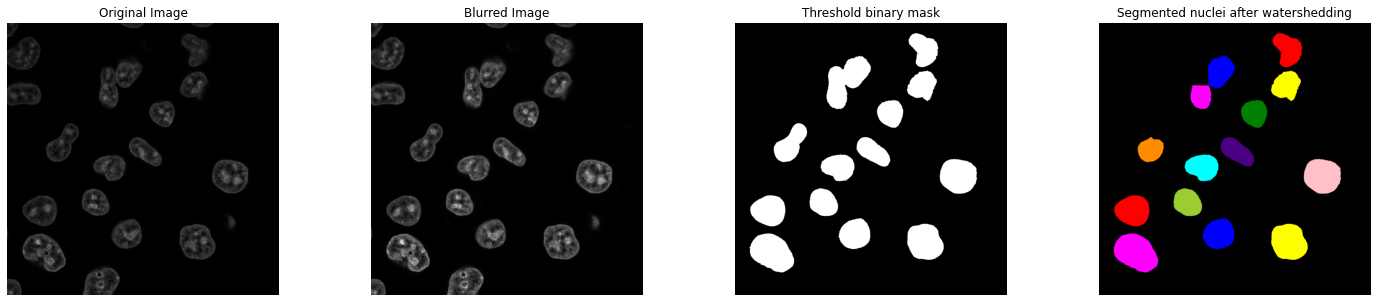

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #5.tif


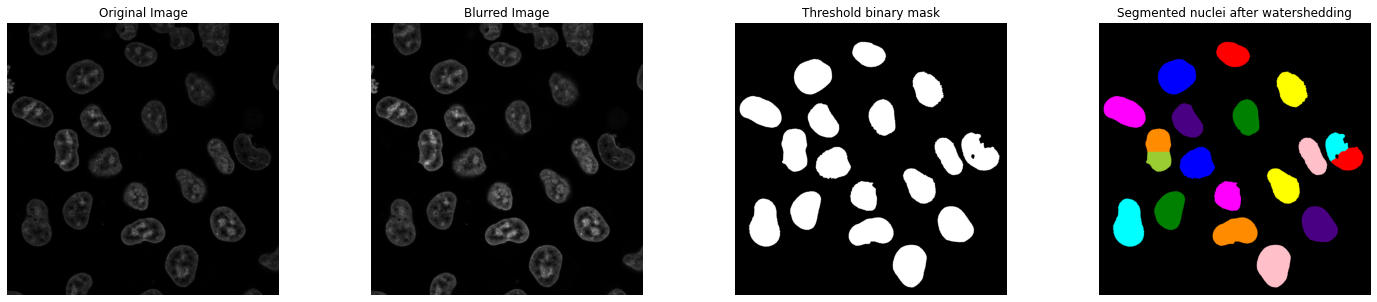

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #6.tif


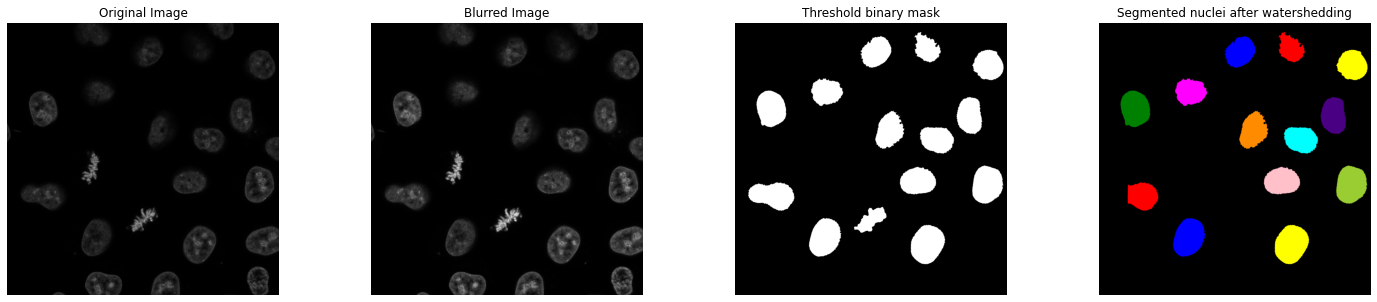

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #7.tif


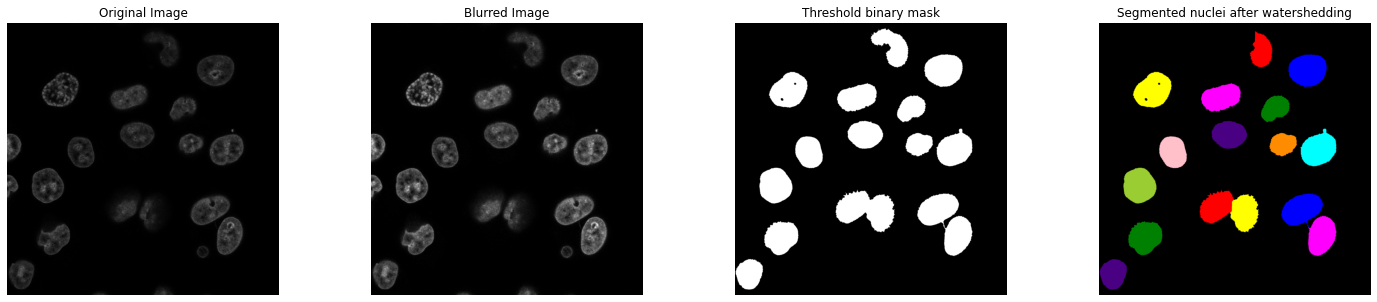

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #8.tif


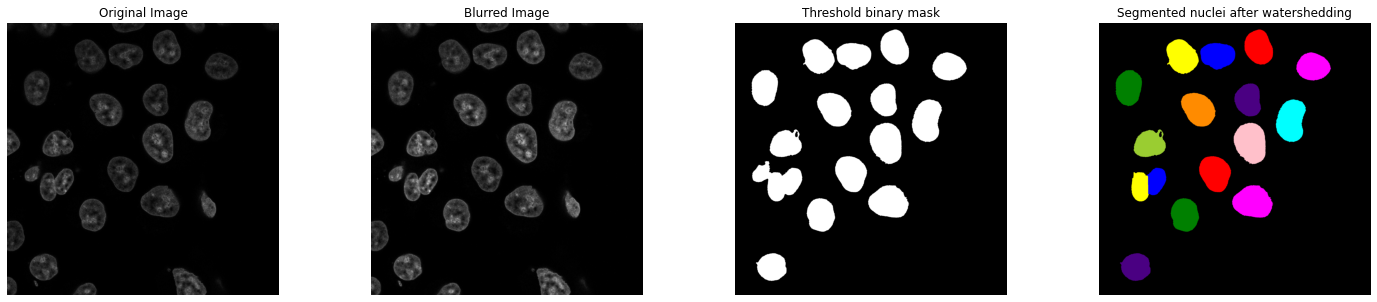

2045_plus_aux_stain_hoechst_nipbl_pos11-19 #9.tif


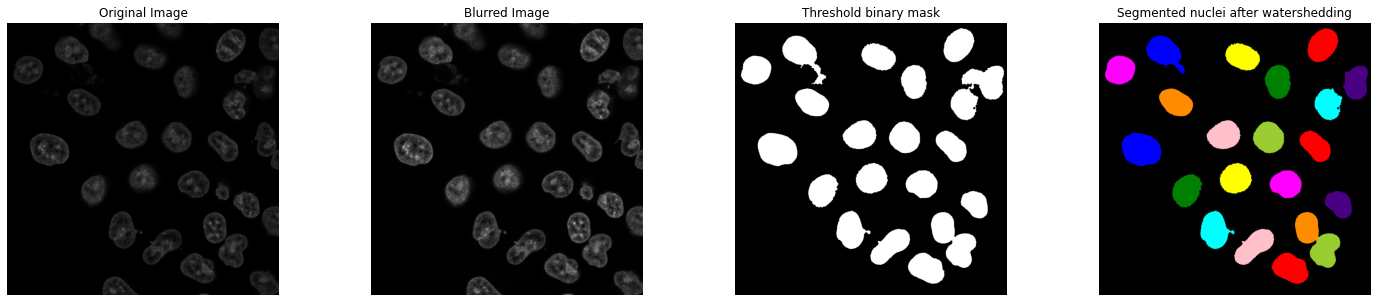

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #1.tif


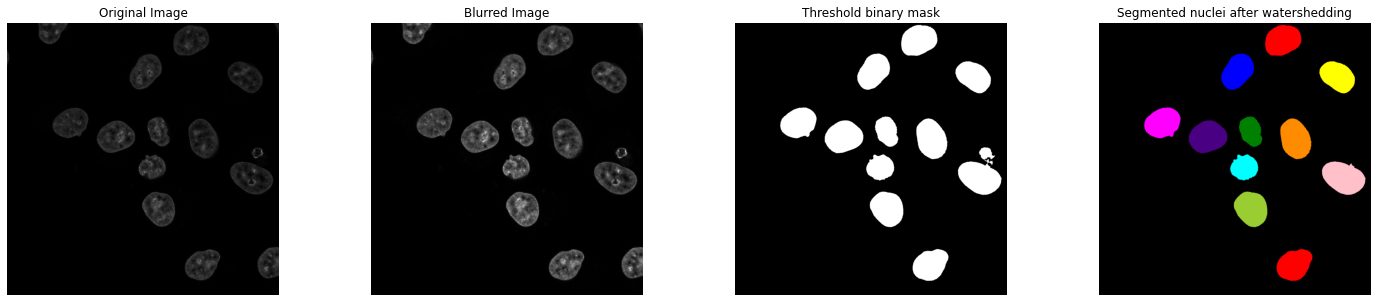

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #2.tif


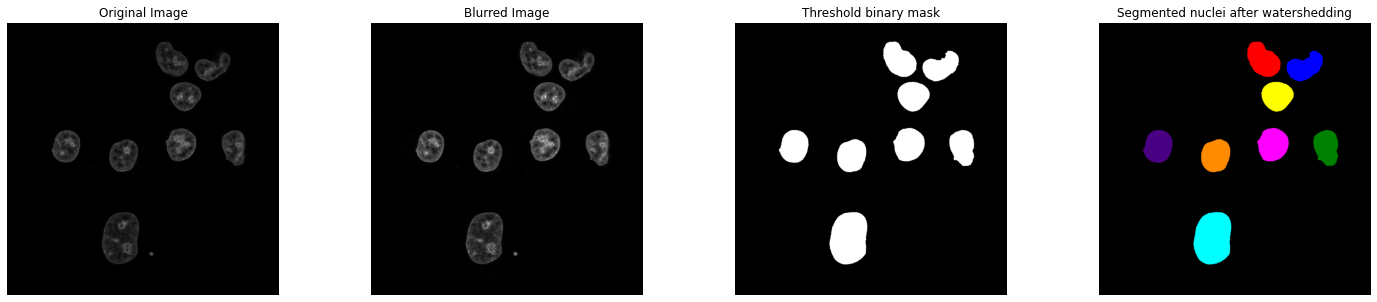

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #3.tif


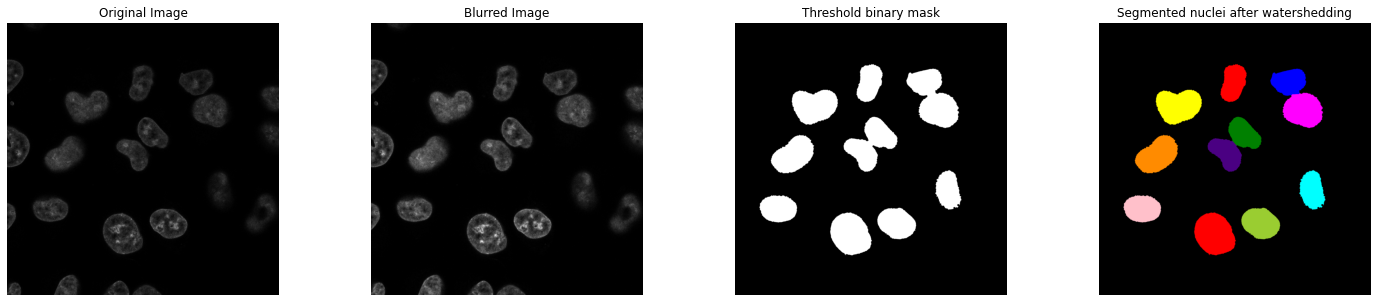

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #4.tif


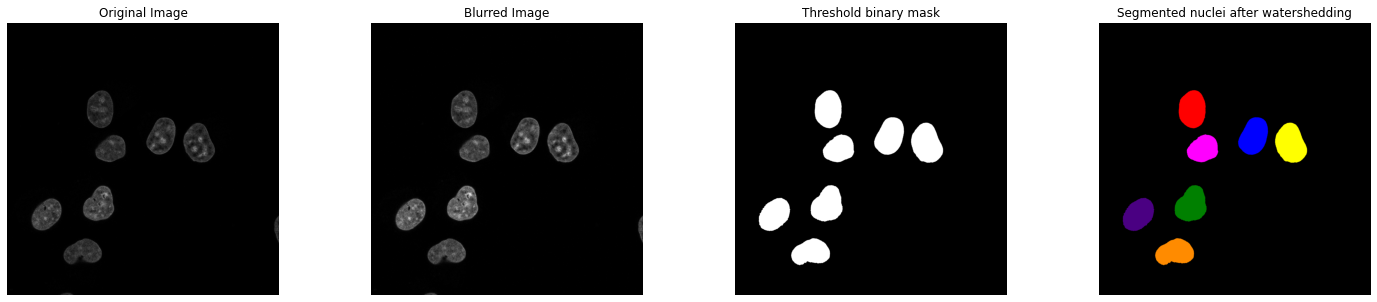

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #5.tif


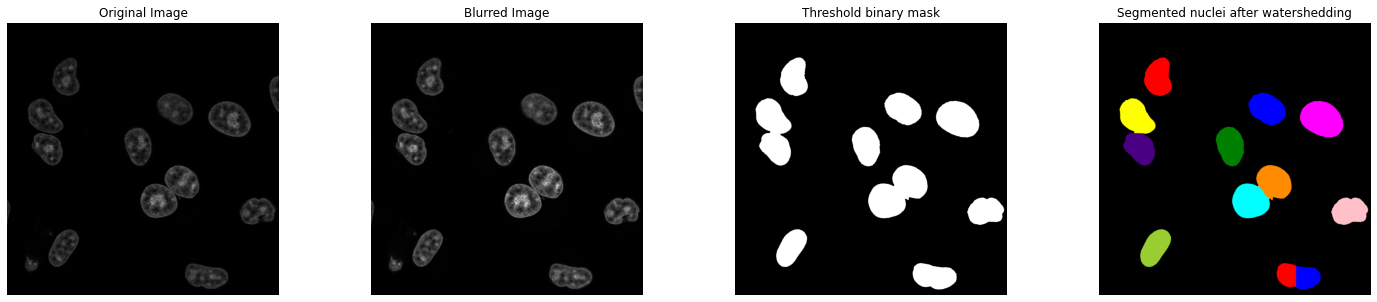

2045_plus_aux_stain_hoechst_nipbl_pos22-25 #6.tif


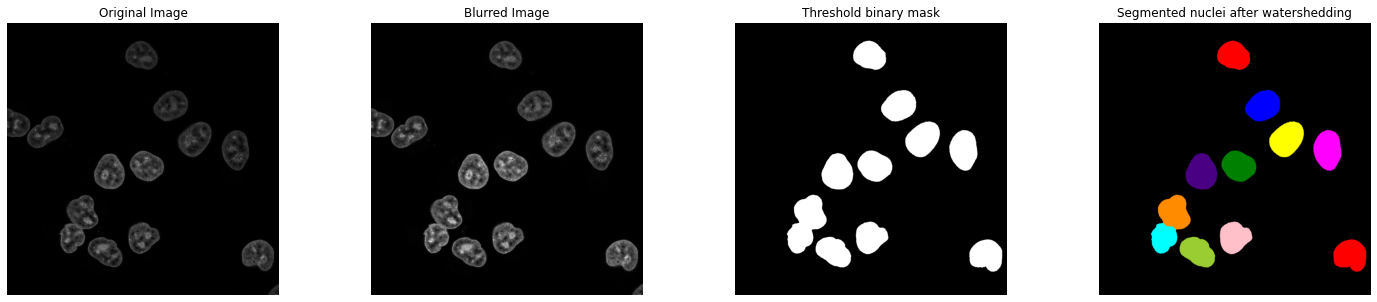

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #01.tif


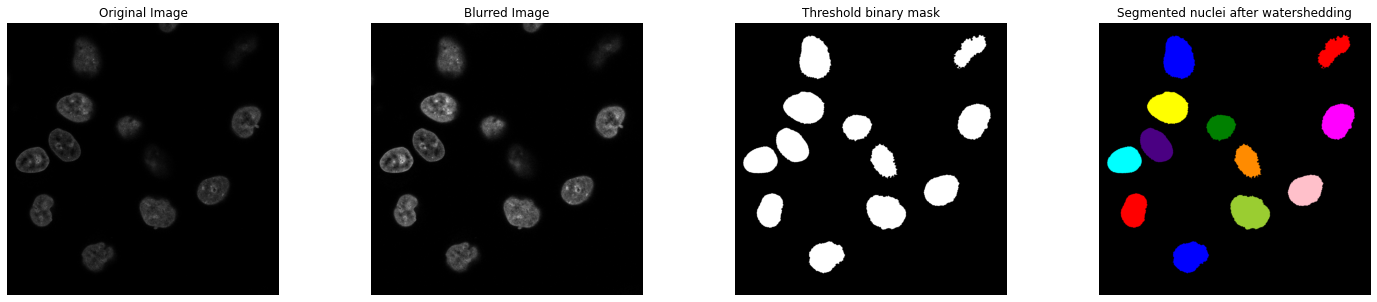

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #02.tif


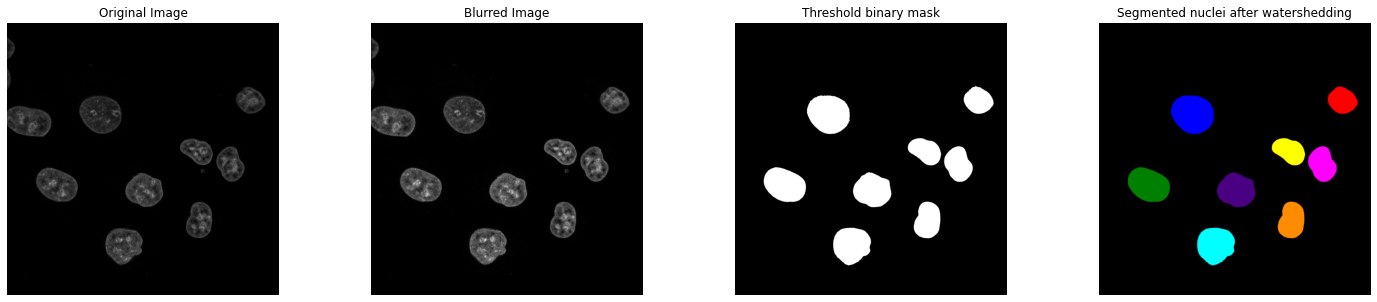

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #03.tif


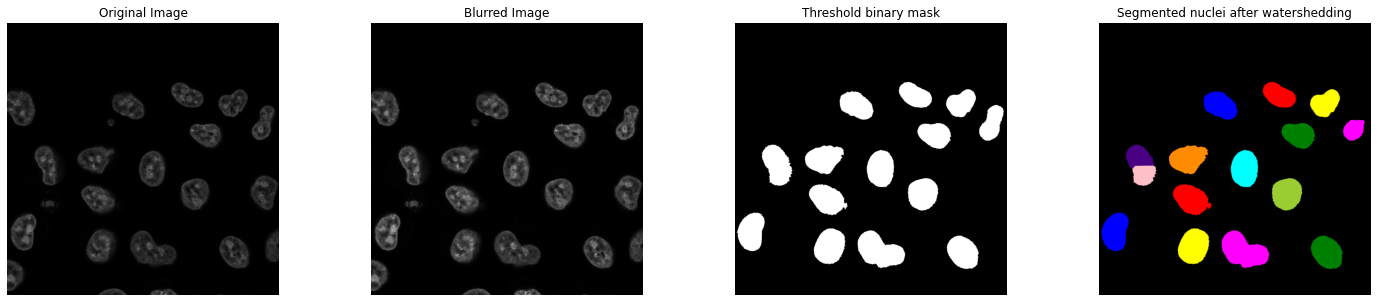

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #04.tif


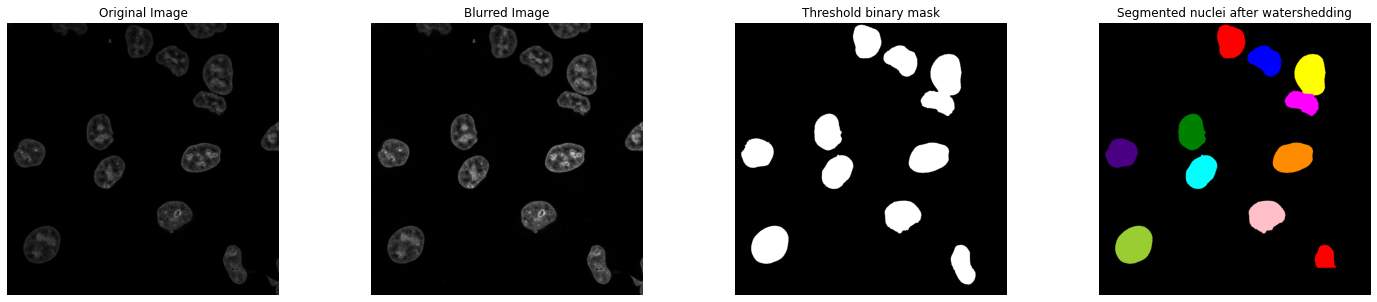

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #05.tif


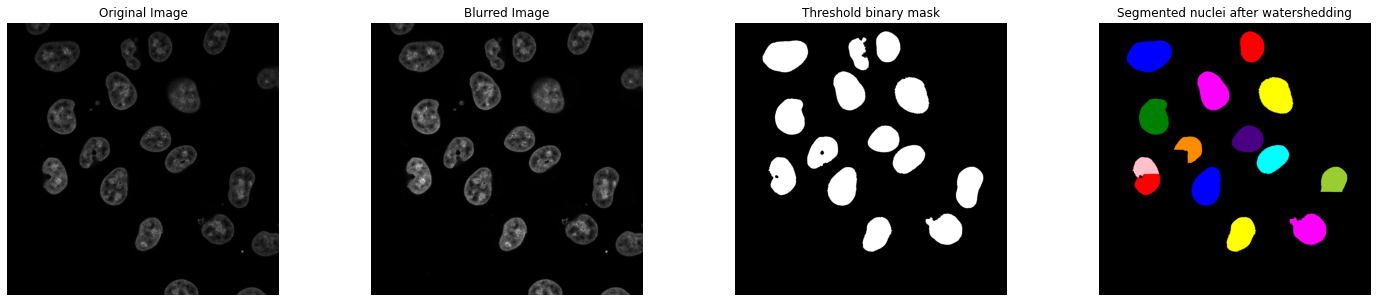

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #06.tif


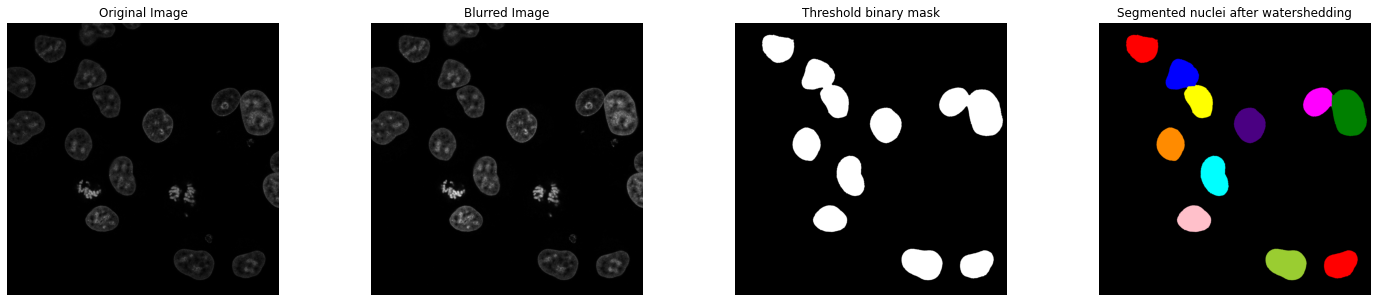

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #07.tif


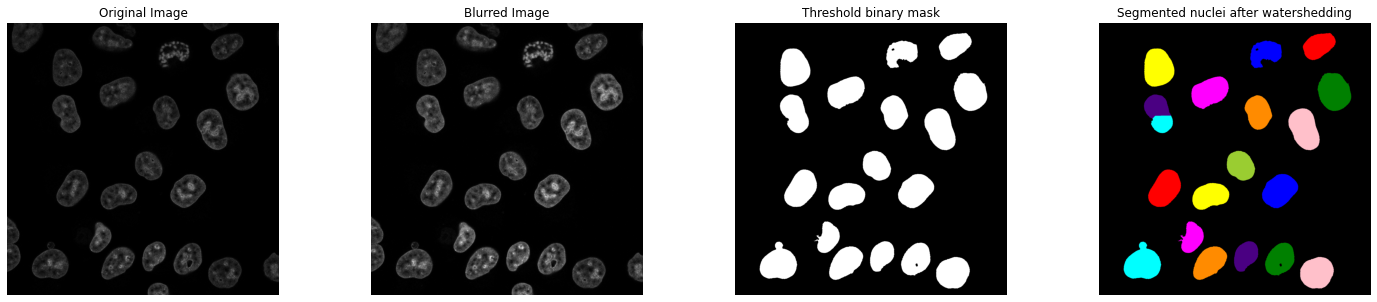

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #08.tif


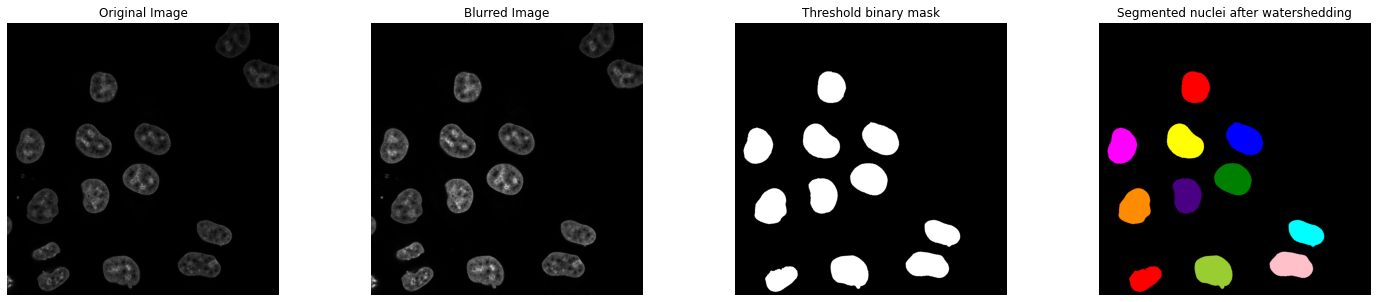

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #09.tif


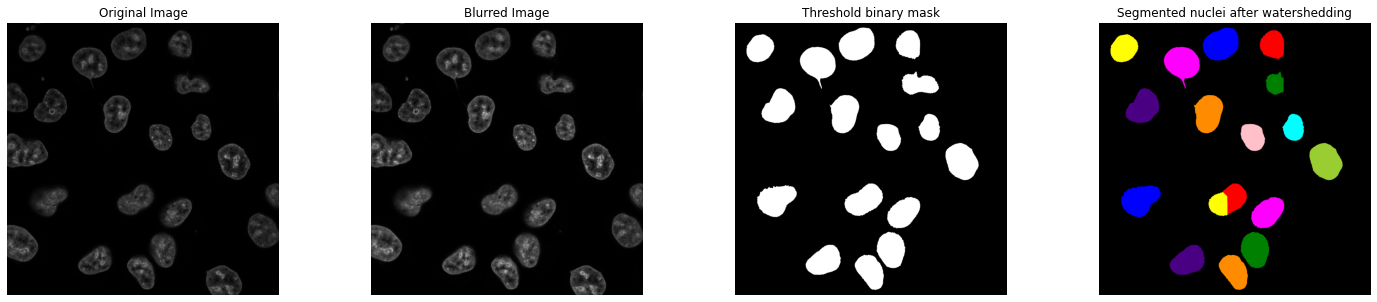

2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10.tif


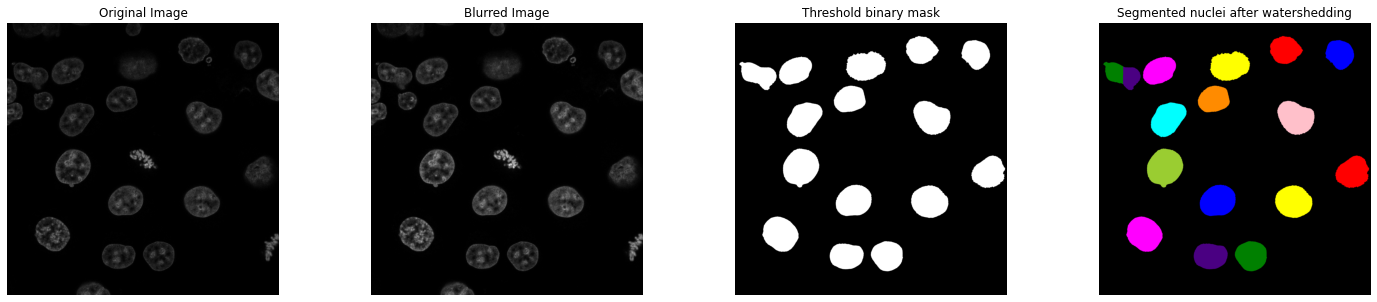

In [11]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt1_220808/2045_plus_auxin/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [12]:
result

image_name  nuclear_area_microns  \
0   2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            195.546311   
1   2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            187.530770   
2   2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            184.820731   
3   2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            196.263674   
4   2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            195.332098   
..                                                ...                   ...   
11  2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            218.337547   
12  2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            229.122907   
13  2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            231.728332   
14  2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            181.771936   
15  2045_plus_aux_stain_hoechst_nipbl_pos26-37 #10...            173.318006   

    mean_hoechst  mean_nipbl  total_hoechst  total_nuclear_nipbl  std_hoechst  \
0      12.925713    8.185897    2527.575432          1600.721886     7.700133   
1      12.425964    8.131867    2330.250658          1524.975277     7.147474   
2      19.955795    8.230404    3688.244639          1521.149338    11.026832   
3      24.007716    8.229814    4711.842621          1615.213625    12.783052   
4      20.615583    8.157995    4026.885038          1593.518361    10.527546   
..           ...         ...            ...                  ...          ...   
11     27.011728    8.210938    5897.674348          1792.756105    13.687125   
12     26.755593    8.186855    6130.319311          1875.795910    13.721670   
13     27.487123    8.284590    6369.545087          1919.774277    16.397940   
14     17.691625    8.077450    3215.840859          1468.253745    11.173166   
15     19.576816    8.102670    3393.014694          1404.338651    11.714740   

    std_nipbl  coeff_variance_hoechst  coeff_variance_nipbl        condition  
0    4.494390                0.595722              0.549041  2045_plus_auxin  
1    4.364351                0.575205              0.536697  2045_plus_auxin  
2    4.493903                0.552563              0.546012  2045_plus_auxin  
3    4.448676                0.532456              0.540556  2045_plus_auxin  
4    4.226711                0.510660              0.518107  2045_plus_auxin  
..        ...                     ...                   ...              ...  
11   4.469341                0.506710              0.544316  2045_plus_auxin  
12   4.458615                0.512852              0.544607  2045_plus_auxin  
13   4.645087                0.596568              0.560690  2045_plus_auxin  
14   4.285720                0.631551              0.530578  2045_plus_auxin  
15   4.391352                0.598399              0.541964  2045_plus_auxin  

[479 rows x 11 columns]

In [57]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [14]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

shape: (2, 1912, 1912)
dtype: uint8
range: (0, 255)


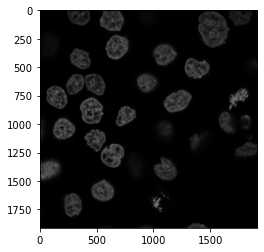

In [15]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
